# Implementation of Kohonen's self-orgianizing maps (SOM, Kohonen map)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from math import exp, sqrt
plt.rcParams['figure.figsize'] = (10,9)
plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [6]:
class SOM():
    '''
        Naive impementation of SOM, inspired by 
        http://www.pymvpa.org/generated/mvpa2.mappers.som.SimpleSOMMapper.html
        All hyperparameters (radius, radius decay, leraning rate, learnign rate decay) are not tuned
        
    '''
    def __init__(self, shape):
        self.h, self.w = shape
        self.r = min(self.h, self.w)
        self.r_decay = 0.99
        self.lr = 0.1
        self.lr_decay = 0.999
        self.K = None
        self.mse = None
        self.eps = 1E-4
    def train(self, data, iterations = 100, boundary='periodic'):
        self.boundary = boundary
        if self.K is None:
            self.d = data.shape[1]
            #self.K = np.random.randn(self.h,self.w,self.d)
            self.K = np.random.random((self.h,self.w,self.d)) # kohonen layer = (defined grid x length of the input data)
        # precompute distance map, cartezian distance is used
        dist_map_periodic      = np.array([[sqrt((i-self.w//2)**2 + (j-self.h//2)**2) for i in range(self.w)] for j in range(self.h)])
        dist_map_nonperiodic   = np.array([[sqrt(i**2 + j**2) for i in range(-self.w,self.w)] for j in range(-self.h,self.h)])
        for _ in trange(iterations):
            # mse error on each iteration
            e = []
            for j in np.random.permutation(data.shape[0]):
                sample = data[j, :]
                # determining the BMU - best matching unit to a given input sample
                diff = sample - self.K
                d2 = (diff**2).sum(axis=-1)
                d_min = np.argmin(d2)
                d_min_x  = d_min % self.w
                d_min_y = d_min // self.w
                if boundary == 'periodic':
                    # periodic boundary conditions
                    d_map = np.roll(np.roll(dist_map_periodic, d_min_x - (self.w//2),axis=1), d_min_y - (self.h//2),axis=0)
                else:
                    d_map = dist_map_nonperiodic[self.h-d_min_y:2*self.h-d_min_y, self.w-d_min_x:2*self.w-d_min_x]
                mask = np.exp(-d_map**2/self.r)
                mask[d_map > self.r] = 0
                self.K += self.lr * mask[:,:,np.newaxis] * diff
                e.append(np.min(d2))
            mse = sum(e)/len(e)    
            if self.mse is None:
                self.mse = [mse]
            elif abs(self.mse[-1] - mse) < self.eps/data.shape[0]:
                break
            else:
                self.mse.append(mse)
            # squeezing of active radius and decay of the learning rate
            self.r *= self.r_decay
            self.lr *= self.lr_decay
    
    def __call__(self, data):
        '''
            Map the data onto kohonen map
            Finds the best matching unit for each data point
        '''
        out = []
        for j in range(data.shape[0]):
            sample = data[j, :]
            diff = sample - self.K
            d2 = (diff**2).sum(axis=-1)
            d_min = np.argmin(d2)
            out.append((d_min % self.w, d_min // self.w))
        return out
    
    @property
    def umatrix(self):
        '''
        naive implementation, needs to be improved
        '''
        m00 = np.roll(np.roll(self.K, 1, axis=0),1, axis=0)
        m01 = np.roll(np.roll(self.K, -1, axis=0),1, axis=0)
        m10 = np.roll(np.roll(self.K, 1, axis=0),-1, axis=0)
        m11 = np.roll(np.roll(self.K, -1, axis=0),-1, axis=0)
        d00 = np.sqrt(((m00-self.K)**2).sum(axis=2))
        d01 = np.sqrt(((m01-self.K)**2).sum(axis=2))
        d11 = np.sqrt(((m11-self.K)**2).sum(axis=2))
        d10 = np.sqrt(((m10-self.K)**2).sum(axis=2))
        u = (d00+d01+d11+d10)/4
        if self.boundary == 'periodic':
            return u
        else:
            return u[1:-1,1:-1]

## Tests

### Colors mapping

In [7]:
'''
A list of colors (RGB) defined together with the names
The grouping of colors is studied
An axample taken from http://www.pymvpa.org/examples/som.html
'''
colors = np.array(
         [[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.5],
          [0.125, 0.529, 1.0],
          [0.33, 0.4, 0.67],
          [0.6, 0.5, 1.0],
          [0., 1., 0.],
          [1., 0., 0.],
          [0., 1., 1.],
          [1., 0., 1.],
          [1., 1., 0.],
          [1., 1., 1.],
          [.33, .33, .33],
          [.5, .5, .5],
          [.66, .66, .66]])

# store the names of the colors for visualization later on
color_names = \
        ['black', 'blue', 'darkblue', 'skyblue',
         'greyblue', 'lilac', 'green', 'red',
         'cyan', 'violet', 'yellow', 'white',
         'darkgrey', 'mediumgrey', 'lightgrey']

In [8]:
som = SOM((60,75))
som.train(colors, 3000)

  2%|▏         | 61/3000 [00:00<00:08, 342.56it/s]


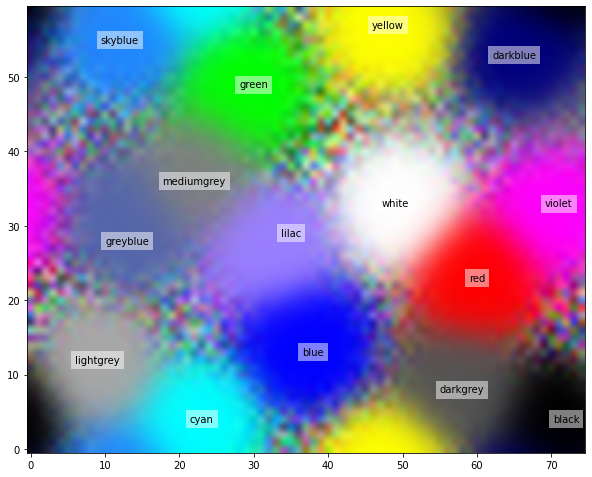

In [9]:
pts = som(colors) # map each color to its location on the map
plt.imshow(som.K, origin='lower', interpolation='spline16')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], color_names[i], va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

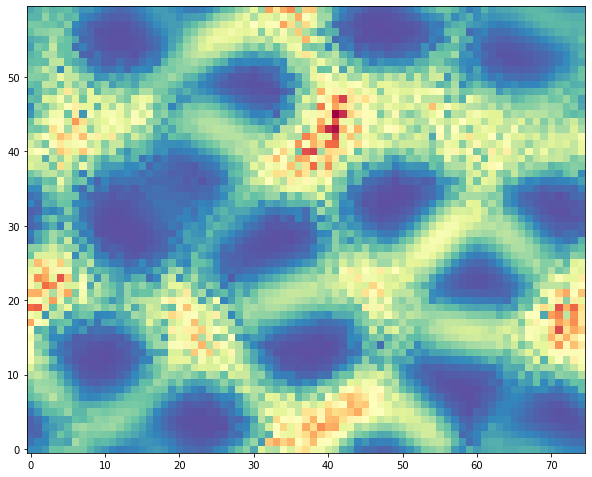

In [10]:
u = som.umatrix
plt.imshow(u,origin='lower',cmap='Spectral_r')

### Test on some random data, threee groups of points on the 2D plane

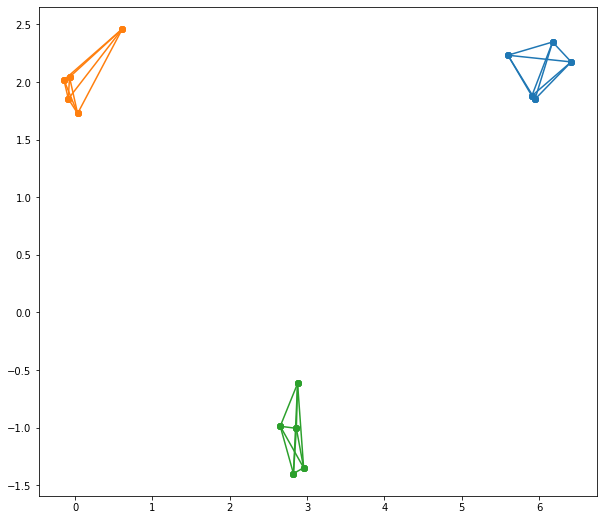

In [12]:
data = np.vstack((np.random.randn(5,2)*0.3+[6, 2], np.random.randn(5,2)*0.3+[0, 2], np.random.randn(5,2)*0.3+[3, -1]))
c = np.array([0]*5+[1]*5+[2]*5) # labels
inds = np.arange(data.shape[0])
for j in range(3):
    ind = c == j
    indx = inds[ind]
    for k in range(len(indx)-1):
        for l in range(k+1, len(indx)):
            plt.plot([data[indx[k]][0],data[indx[l]][0]], [data[indx[k]][1],data[indx[l]][1]],'o-', c=f'C{j}')

In [13]:
som = SOM((20,30))
som.train(data, 1000, 'nonperiodic')

  9%|▉         | 92/1000 [00:00<00:00, 1446.64it/s]


In [ ]:
pts = som(data)

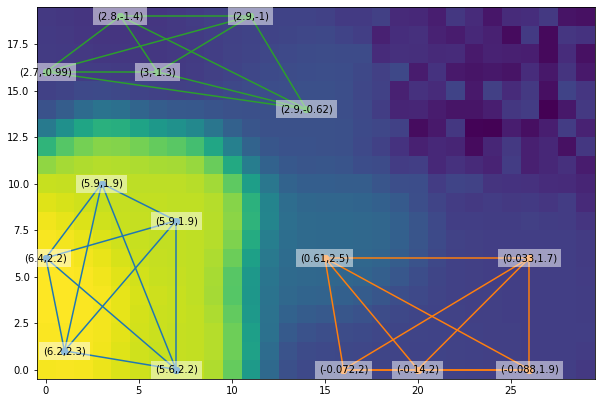

In [17]:
plt.imshow(som.K.mean(axis=2),origin='lower')
inds = np.arange(len(pts))
for j in range(3):
    ind = c == j
    indx = inds[ind]
    for k in range(len(indx)-1):
        for l in range(k+1, len(indx)):
            plt.plot([pts[indx[k]][0],pts[indx[l]][0]], [pts[indx[k]][1],pts[indx[l]][1]],'o-', c=f'C{j}')
for i, pt in enumerate(pts):
    plt.text(pt[0], pt[1], f'({data[i, 0]:1.2g},{data[i, 1]:1.2g})', va='center', ha='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

### Fancy: test on IRIS data

In [18]:
from sklearn.datasets import load_iris
iris = load_iris()
data = iris['data']
c = iris['target']
data = (data - data.min())/(data.max()-data.min()) # Normalize data to [0,1] range

In [19]:
som = SOM((60,60))
som.train(data, 1000, 'periodic')

  3%|▎         | 32/1000 [00:00<00:25, 37.83it/s]


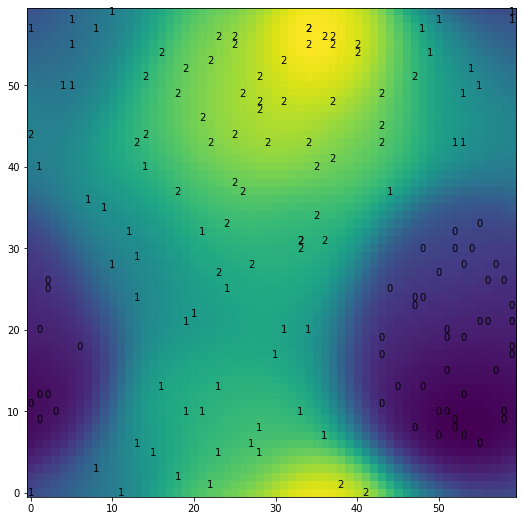

In [20]:
pts = som(data)
pts_ = np.array(pts)
plt.imshow(som.K.sum(axis=2),origin='lower')
#plt.scatter(pts_[:,0], pts_[:,1], c=c, alpha=0.25,s=50,cmap='viridis')
for i in range(len(pts)):
    plt.text(pts_[i,0], pts_[i,1],c[i], va='center',ha='center')

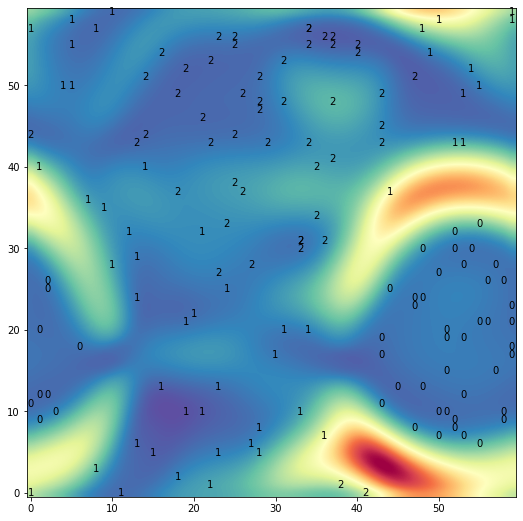

In [22]:
u = som.umatrix
plt.imshow(u, origin='lower', cmap='Spectral_r', interpolation='spline16')
for i in range(len(pts)):
    plt.text(pts_[i,0], pts_[i,1],c[i], va='center',ha='center')

### Test on MNIST dataset - handwritten digits

In [23]:
from sklearn import datasets
# load the digits dataset from scikit-learn
digits = datasets.load_digits(n_class=10)
data = digits.data  # matrix where each row is a vector that represent a digit.
data = data/data.max(axis=1, keepdims=True)
num = digits.target  # num[i] is the digit represented by data[i]

In [24]:
data.shape # here we have 1797 handwritten digits as 8x8 b/w images

(1797, 64)

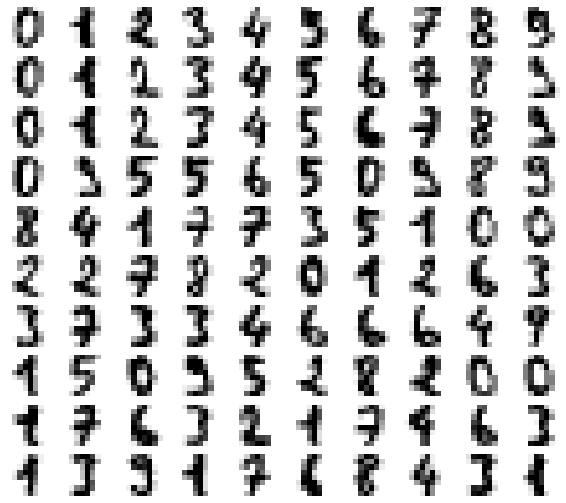

In [25]:
N = 10
for j in range(N*N):
    d = data[j, :].reshape((8,8))
    plt.subplot(N,N,j+1)
    plt.imshow(d,cmap='gray_r')#, interpolation='spline16')
    plt.axis('off')

In [ ]:
som = SOM((40,40))
som.train(data, 1000, 'periodic')

 65%|██████▌   | 653/1000 [06:00<03:13,  1.80it/s]

In [132]:
pts = som(data)
pts_ = np.array(pts)
#plt.imshow(som.K.sum(axis=2),origin='lower')
pts_ = pts_ + (np.random.random(pts_.shape)-0.5)*0.95

In [133]:
from matplotlib.pyplot import get_cmap
from matplotlib.colors import ListedColormap
cmap = get_cmap('Set1',9)
cols = ListedColormap([(0,0,0,1.0), *[cmap(i) for i in range(9)]]) # We need 10 distinct colors. black + Set1

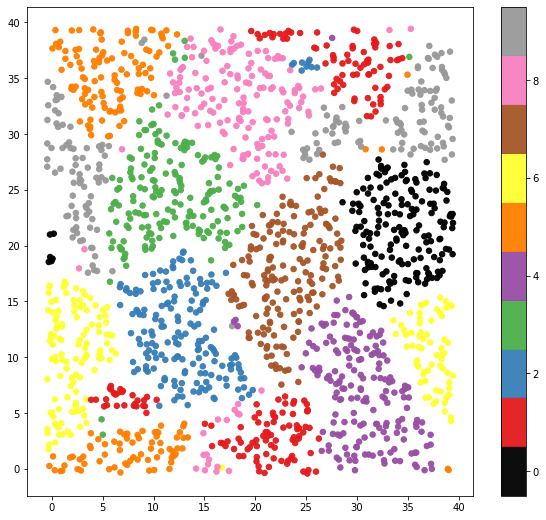

In [134]:
#plt.scatter(pts_[:,0], pts_[:,1], alpha=0.0,s=50,cmap='viridis')
plt.scatter(pts_[:,0], pts_[:,1], c=num, alpha=0.95,s=30,cmap=cols)
plt.colorbar()
plt.clim(-0.5,9.5)
'''
L = []
for i in range(len(pts)):
    d = num[i]
    if not d in L:
        plt.text(pts_[i,0], pts_[i,1],d, va='center',ha='center',fontsize=40,c=cols(d))
        L.append(d)
        if len(L) == 10:
            break
'''
plt.savefig('digits2.png',dpi=150, bbox_inches='tight')